Commit Qty Analysis, using XGBoost and SHAP

`To apply SHAP, we need to have a model to explain. SHAP values are used to explain the output of machine learning models and to understand the contribution of each feature to a prediction.`

In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


# Load the dataset
data = pd.read_csv("cleaned_bd.csv")

# Display the first few rows
data.head()


,Ship To,Customer Name,Customer Part.,Mfr,Item No,Order Number,Date Ordered,Date Required,Qty Required,Qty Allocated,...,Weight(grams),Stock Asia,Stock Asia Available,Stock Canada,Stock Canada Available,Stock Europe,Stock Europe Available,Stock US,Stock US Available,Business Unit
0,JS005B00,JABIL VIETNAM CO. LTD.,189103664,DIO,7388556,BIM-JABIL VN-SMCI,01/15/2016,01/01/2030,6000,0,...,318.0,129000,42000,0,0,108000,105000,0,0,Small Signal Discretes
1,JS004000,JABIL VIETNAM CO. LTD,SND1DDE002302-NR,DIO,4456992,4508650451,12/14/2021,09/22/2023,117000,0,...,5152.0,825000,411000,0,0,231000,108000,558000,174000,Small Signal Discretes
2,JS004000,JABIL VIETNAM CO. LTD,CA763-00012-LC,DIO,7091728,4508909383,02/13/2022,09/09/2023,3000,0,...,340.0,30000,30000,0,0,3000,0,0,0,Discretes
3,JS004000,JABIL VIETNAM CO. LTD,SEECS-FT-20060-LF,DIO,7362841,4509263942,05/04/2022,09/09/2023,258000,0,...,6880.0,3648000,537000,0,0,582000,0,42000,30000,Small Signal Discretes
4,JS080200,JABIL VIETNAM CO. LTD.,SW5010155,DIO,2132320,1852055747,08/04/2022,09/12/2023,51000,0,...,6120.0,1776000,948000,0,0,0,0,0,0,Discretes


First We have to clean our target column. because there are so many wrong human entries out there. we only need a unit numbers.

In [2]:
data["Current Customer Commit"].sample(20)

830                              15000 units - 2023/11/06
472                              20000 units - 2024/01/29
477                              20000 units - 2023/12/04
129                              81000 units - 2023/11/15
947                               3000 units - 2023/11/28
77                              174000 units - 2023/10/04
204                              12000 units - 2024/03/18
13                              Qty: 3000 - Man-Alloc-ATS
940              32000 units - 2023/10/24;\nBond Exists\n
526                              69000 units - 2023/11/06
983                              27000 units - 2023/10/02
125                              60000 units - 2023/11/22
135                              12000 units - 2023/11/06
103                              42000 units - 2024/05/06
1074    Qty: 184000 - Asset Purchase in Process 202307...
792                                    Bond at 0 quantity
336                              84000 units - 2023/10/27
380           

`let's start by cleaning the "current customer commit" column to extract the required numerical values.`

In [3]:
import re

# Function to extract numeric values from the 'Current Customer Commit' column
def extract_numeric_value(s):
    # Extract numeric values using regex
    result = re.search(r'\d+', s)
    return int(result.group()) if result else None

# Apply the function to the column
data['Current Customer Commit'] = data['Current Customer Commit'].apply(extract_numeric_value)

# Display the cleaned column
data['Current Customer Commit'].head(10)

0      6000.0
1    117000.0
2      3000.0
3    258000.0
4     51000.0
5     54000.0
6      2000.0
7     57000.0
8     78000.0
9    300000.0
Name: Current Customer Commit, dtype: float64

We have cleaned the "Current Customer Commit" column , and the extracted numerical values we stored in the "Current Customer Commit" column again.

## Data Preprocessing Steps:

1. **Handle Missing Values**: 
    -  We'll Remove rows with missing target values.
    
        
2. **Encode Categorical Variables**:
    -  We'll Convert categorical variables to numerical format using one-hot encoding
    
    
3. **Data Split**

    - We'll divide the dataset into training and test sets to validate the model's performance.


In [4]:
# Further Data Preprocessing

# 1. Handle Missing Values
# Check for missing values in the dataset
missing_values = data.isnull().sum()


# 2. Encoding Categorical Variables
categorical_columns = data.select_dtypes(include=['object']).columns
data_encoded = pd.get_dummies(data, columns=categorical_columns, drop_first=True)

# 3. Data Splitting
X = data_encoded.drop(columns=['Current Customer Commit'])
y = data_encoded['Current Customer Commit']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display missing values 
missing_values

Ship To                     0
Customer Name               0
Customer Part.              0
Mfr                         0
Item No                     0
Order Number                0
Date Ordered                0
Date Required               0
Qty Required                0
Qty Allocated               0
Current Customer Commit    33
Current Commit Date         0
Resale Price                0
Value USD                   0
Value Alloc USD             0
LeadTime                    0
Product Type                0
MPQ                         0
Class                       0
Usage Last Month            0
Usage 2 Mths ago            0
Usage 3 Mths ago            0
Total PBO Qty               0
Country Of Origin           0
Weight(grams)               0
Stock Asia                  0
Stock Asia Available        0
Stock Canada                0
Stock Canada Available      0
Stock Europe                0
Stock Europe Available      0
Stock US                    0
Stock US Available          0
Business U

In [5]:
# shape of the training data
X_train.shape, y_train.shape

((870, 2222), (870,))

- From the selected columns, only the `Current Customer Commit` column has missing values (`33` missing entries).

- For this column, since it's our target variable, we need to drop rows with missing values, as imputation should introduce bias.

- For the features (independent variables), there are no missing values, which is great for us.

In [6]:
# Drop rows with missing values in the 'Current Customer Commit' column
data_encoded = data_encoded.dropna(subset=['Current Customer Commit'])

# Split the data again after dropping missing values
X = data_encoded.drop(columns=['Current Customer Commit'])
y = data_encoded['Current Customer Commit']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shape of the training data after dropping missing values
X_train.shape, y_train.shape

((844, 2222), (844,))

### Part 2. Model Training:

In this phase, we'll:

- **Choose a Regression Model**: Given the nature of our target variable (a continuous numeric value), we'll use a regression model. The XGBoost regressor is a powerful and versatile choice that's compatible with SHAP, so we'll use that.
- **Train the Model**: We'll train the XGBoost regressor on the training set.
- **Evaluate Initial Performance**: After training, we'll evaluate the model's performance on the training data using the Root Mean Squared Error (RMSE) to ensure it's learning.

In [7]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np

# Initialize the XGBoost regressor
xgb_regressor = xgb.XGBRegressor(objective ='reg:squarederror', n_estimators=100)

# Train the model
xgb_regressor.fit(X_train, y_train)

# Predict on the training data
y_train_pred = xgb_regressor.predict(X_train)

# Calculate RMSE on the training data
rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse

1438.4887318023157

The Root Mean Squared Error (RMSE) on the training data is approximately **1438.49.** This metric provides an indication of the model's performance, with lower values indicating better performance.



### Part 3: SHAP Analysis.

SHAP values provide a measure of the impact of each feature on the model's prediction for a particular instance. The SHAP value for a feature is the average contribution of that feature to every possible prediction.

Steps for SHAP analysis:

- **Compute SHAP Values**:
  - We'll use the SHAP library to compute SHAP values for the trained XGBoost model.

- **SHAP Summary Plot**:
  - This plot provides a birds-eye view of feature importance and what is driving it. Each point on the summary plot is a SHAP value for a feature and an instance. The position on the y-axis is determined by the feature, and the position on the x-axis is determined by the SHAP value.

In [9]:
#!pip install shap

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


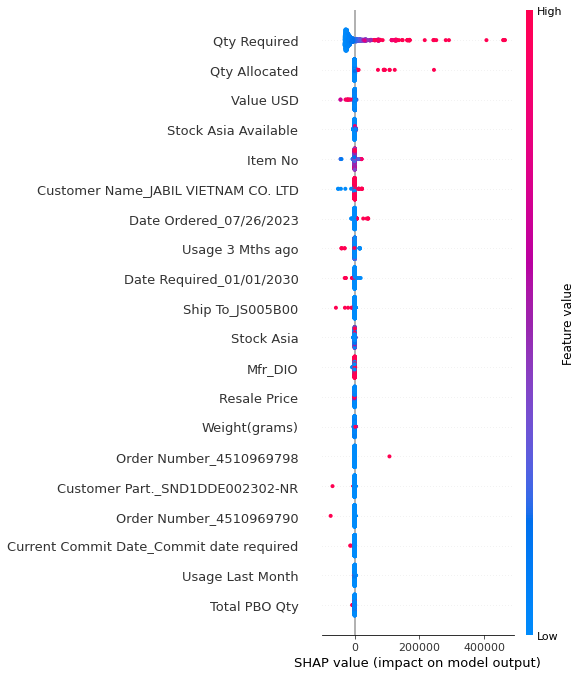

In [8]:
import shap

# Initialize the SHAP explainer
explainer = shap.Explainer(xgb_regressor)

# Compute SHAP values for the training data
shap_values = explainer.shap_values(X_train)

# Display the SHAP summary plot
shap.summary_plot(shap_values, X_train)

In [9]:
import numpy as np

In [10]:
# Calculate summary statistics
mean_abs_shap = np.abs(shap_values).mean(axis=0)
std_shap = shap_values.std(axis=0)

# Create a DataFrame for SHAP values
shap_df = pd.DataFrame(shap_values, columns=X.columns)

# Add summary statistics to the DataFrame
shap_df.loc['mean_abs_shap'] = mean_abs_shap
shap_df.loc['std_shap'] = std_shap

# Transpose the DataFrame for better visualization
shap_df = shap_df.T

# Filter out values not equal to 0
shap_summary = shap_df[shap_df != 0].dropna()

# Select only the desired columns (index, mean, std)
shap_summary = shap_summary[['mean_abs_shap', 'std_shap']]

# Rename the first column to 'Title'
shap_summary = shap_summary.rename_axis('Factors')

# Save the extracted DataFrame to a CSV file
shap_summary.to_csv('shap_values_summary.csv')

The SHAP summary plot provides the following insights:

1. **Feature Importance**: The features are ordered by the sum of SHAP value magnitudes over all samples. The top features have the most impact on the model's predictions, while the bottom ones have the least impact.
2. **Feature Impact**: The color represents the feature value (red is high, blue is low). For instance, higher values of a feature pushing the prediction higher (to the right) would indicate a positive correlation with the target variable.
3. **Feature Value Distribution**: The density of the color shows the density of the data. For example, vertical lines or "beeswarm" points show the distribution of the feature values in the dataset.

`The bar graph is easier to understand compared to the compact_dot graph. After viewing the bar graph, we can easily determine which features contribute the most to model performance..`

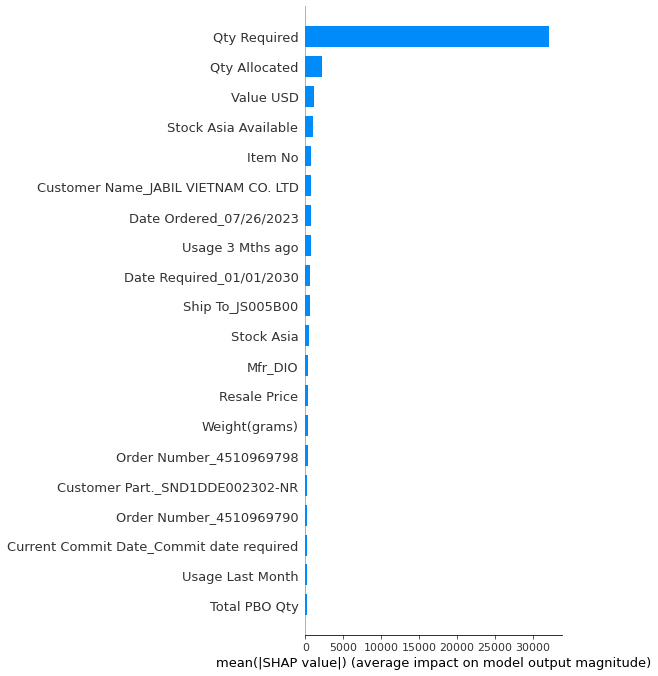

In [11]:
# Create a bar plot for SHAP values
shap.summary_plot(shap_values, X_train, plot_type='bar')

### SHAP Bar Plot Summary Interpretation:

The SHAP summary plot provides insights into the importance of different features in predicting the "Current Customer Commit" column. Here's an interpretation of the plot:

1. **Qty Required**: This feature has the longest bar in the plot, indicating the highest average SHAP value magnitude. It contributes the most to the model's predictions, especially for values above 30000. Its influence on the model's output is substantial, and it plays a key role in determining the predictions.

2. **Qty Allocated**: The second most important feature, with a contribution close to 4000. It has a significant impact on the model's predictions, though not as strong as "Qty Required."

3. **Value USD and Stock Asia Available**: These two features have almost equal contributions to the model's predictions. They are influential but to a lesser extent compared to the top two features.

4. **Remaining Features**: The rest of the features contribute very little to the model's predictions. Their influence is minimal, and they have a lower impact on the model's output.

Overall, the SHAP summary plot reveals that "Qty Required" is the most influential feature, followed by "Qty Allocated." The other features have a lesser impact, with "Value USD" and "Stock Asia Available" having moderate contributions. 

Commit Date Analysis

In [13]:
# Convert the date columns to datetime format
data['Date Ordered'] = pd.to_datetime(data['Date Ordered'], errors='coerce')
data['Date Required'] = pd.to_datetime(data['Date Required'], errors='coerce')
data['Current Commit Date'] = pd.to_datetime(data['Current Commit Date'], errors='coerce')

# Calculate the 'Days Late'
data['Days Late'] = (data['Date Required'] - data['Current Commit Date']).dt.days

# Display the first few rows with the new 'Days Late' column
data[['Date Ordered', 'Date Required', 'Current Commit Date', 'Days Late']].head()

,Date Ordered,Date Required,Current Commit Date,Days Late
0,2016-01-15,2030-01-01,NaT,NaN
1,2021-12-14,2023-09-22,NaT,NaN
2,2022-02-13,2023-09-09,NaT,NaN
3,2022-05-04,2023-09-09,NaT,NaN
4,2022-08-04,2023-09-12,NaT,NaN


In [14]:
data.isnull().sum()

Ship To                      0
Customer Name                0
Customer Part.               0
Mfr                          0
Item No                      0
Order Number                 0
Date Ordered                 0
Date Required                0
Qty Required                 0
Qty Allocated                0
Current Customer Commit     33
Current Commit Date        176
Resale Price                 0
Value USD                    0
Value Alloc USD              0
LeadTime                     0
Product Type                 0
MPQ                          0
Class                        0
Usage Last Month             0
Usage 2 Mths ago             0
Usage 3 Mths ago             0
Total PBO Qty                0
Country Of Origin            0
Weight(grams)                0
Stock Asia                   0
Stock Asia Available         0
Stock Canada                 0
Stock Canada Available       0
Stock Europe                 0
Stock Europe Available       0
Stock US                     0
Stock US

In [15]:
# Calculate the proportion of missing values in the 'Current Commit Date' column
missing_proportion = data['Current Commit Date'].isnull().sum() / len(data)

missing_proportion

0.16176470588235295

In [16]:
# Drop rows with missing 'Current Commit Date' values
df_cleaned = data.dropna(subset=['Current Commit Date'])

# Verify the changes by checking the proportion of missing values in the 'Current Commit Date' column again
missing_proportion_cleaned = df_cleaned['Current Commit Date'].isnull().sum() / len(df_cleaned)

missing_proportion_cleaned

0.0

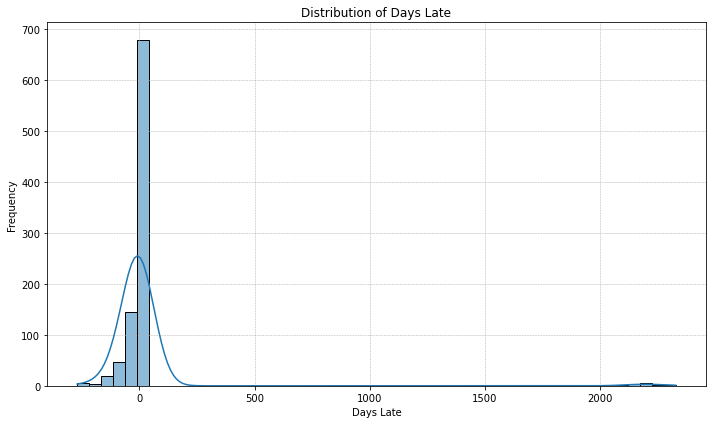

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the distribution of 'Days Late'
plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned['Days Late'], bins=50, kde=True)
plt.title('Distribution of Days Late')
plt.xlabel('Days Late')
plt.ylabel('Frequency')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

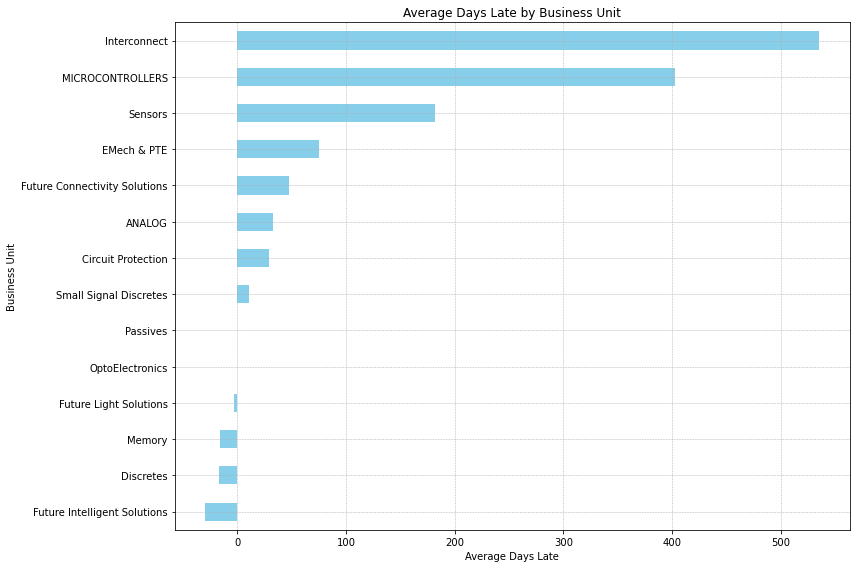

In [18]:
# Group by 'Business Unit' and calculate the average 'Days Late' for each unit
business_unit_lateness = df_cleaned.groupby('Business Unit')['Days Late'].mean().sort_values()

# Plotting the average 'Days Late' by 'Business Unit'
plt.figure(figsize=(12, 8))
business_unit_lateness.plot(kind='barh', color='skyblue')
plt.title('Average Days Late by Business Unit')
plt.xlabel('Average Days Late')
plt.ylabel('Business Unit')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

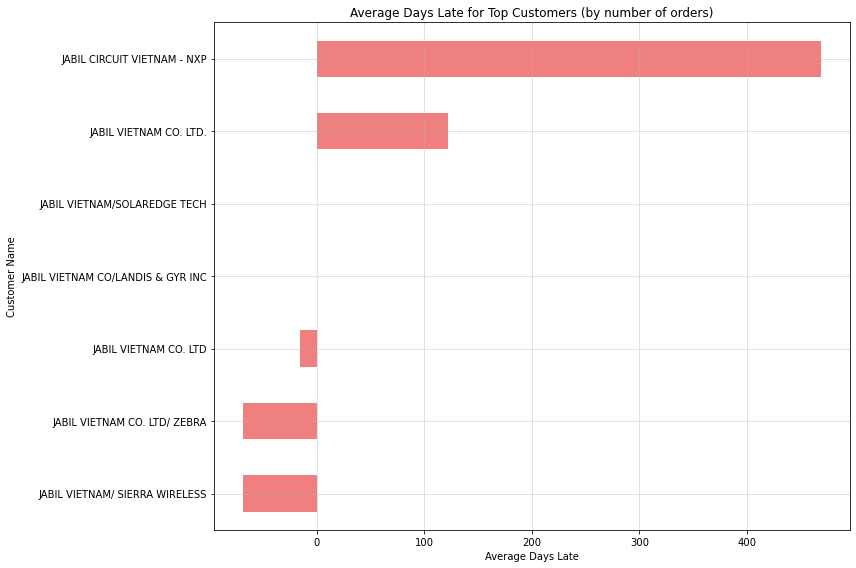

In [19]:
# Group by 'Customer Name' and calculate the average 'Days Late' and count of orders for each customer
customer_lateness = df_cleaned.groupby('Customer Name').agg({'Days Late': 'mean', 'Order Number': 'count'})

# Select top customers based on the number of orders
top_customers = customer_lateness.sort_values(by='Order Number', ascending=False).head(10)

# Plotting the average 'Days Late' for top customers
plt.figure(figsize=(12, 8))
top_customers['Days Late'].sort_values().plot(kind='barh', color='lightcoral')
plt.title('Average Days Late for Top Customers (by number of orders)')
plt.xlabel('Average Days Late')
plt.ylabel('Customer Name')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

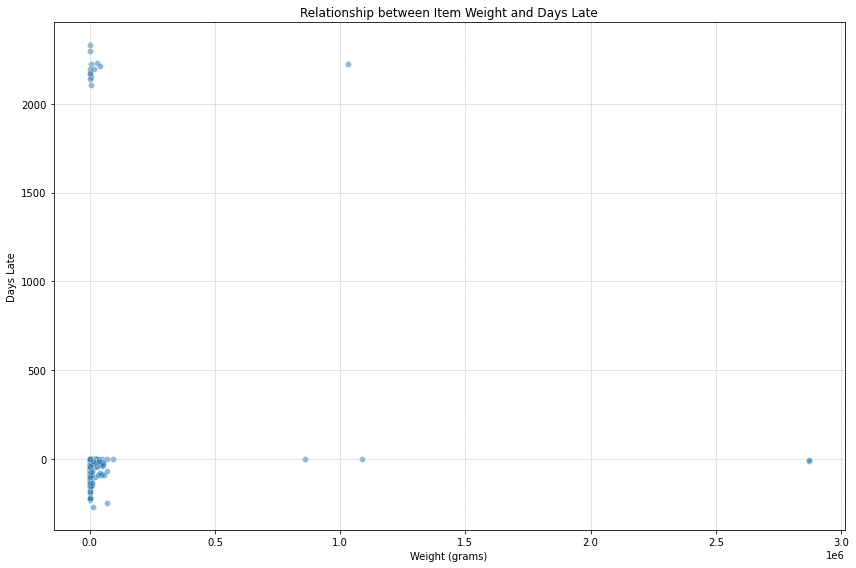

In [20]:
# Scatter plot of 'Weight(grams)' vs 'Days Late'
plt.figure(figsize=(12, 8))
sns.scatterplot(x=df_cleaned['Weight(grams)'], y=df_cleaned['Days Late'], alpha=0.5)
plt.title('Relationship between Item Weight and Days Late')
plt.xlabel('Weight (grams)')
plt.ylabel('Days Late')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

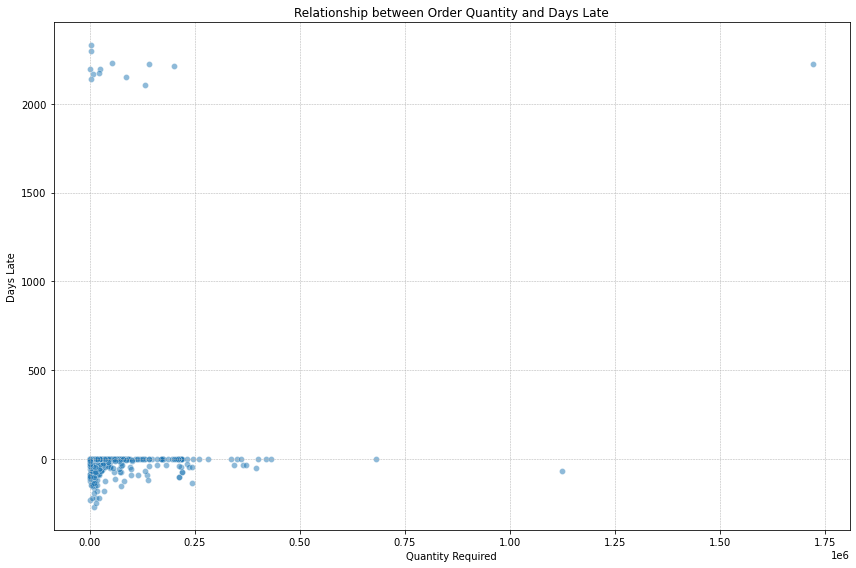

In [21]:
# Scatter plot of 'Qty Required' vs 'Days Late'
plt.figure(figsize=(12, 8))
sns.scatterplot(x=df_cleaned['Qty Required'], y=df_cleaned['Days Late'], alpha=0.5)
plt.title('Relationship between Order Quantity and Days Late')
plt.xlabel('Quantity Required')
plt.ylabel('Days Late')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


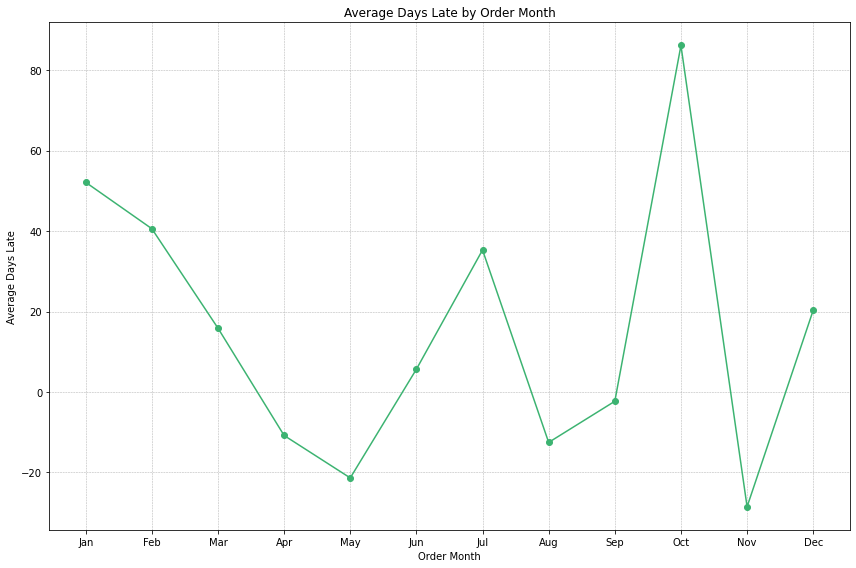

In [22]:
# Extracting the month from the 'Date Ordered' column
df_cleaned['Order Month'] = df_cleaned['Date Ordered'].dt.month

# Grouping by 'Order Month' and calculating the average 'Days Late' for each month
monthly_lateness = df_cleaned.groupby('Order Month')['Days Late'].mean()

# Plotting the average 'Days Late' by order month
plt.figure(figsize=(12, 8))
monthly_lateness.plot(kind='line', marker='o', color='mediumseagreen')
plt.title('Average Days Late by Order Month')
plt.xlabel('Order Month')
plt.ylabel('Average Days Late')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.tight_layout()
plt.show()

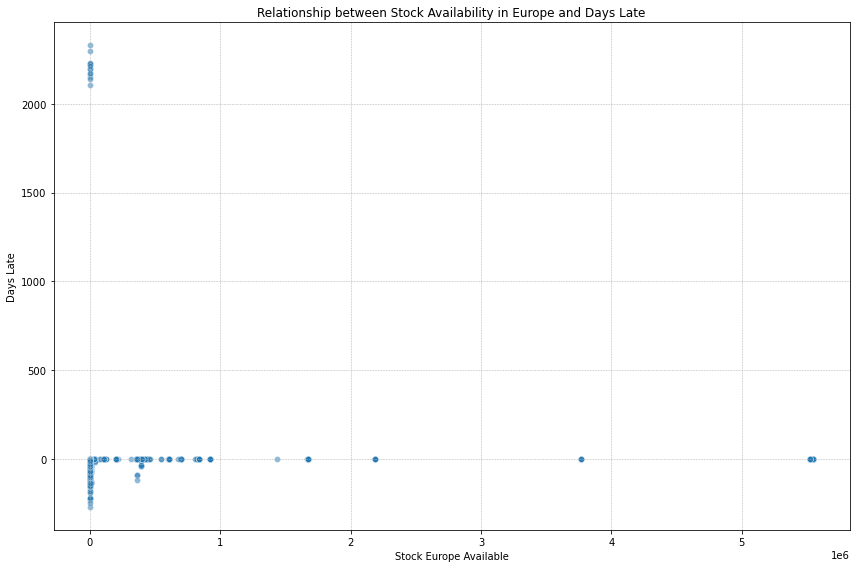

In [23]:
# Scatter plot of 'Stock Europe Available' vs 'Days Late'
plt.figure(figsize=(12, 8))
sns.scatterplot(x=df_cleaned['Stock Europe Available'], y=df_cleaned['Days Late'], alpha=0.5)
plt.title('Relationship between Stock Availability in Europe and Days Late')
plt.xlabel('Stock Europe Available')
plt.ylabel('Days Late')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

In [24]:
df_cleaned.to_csv('Days_late_summary.csv', index=False)